In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext("local", "pyspark-shell")

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Machine Learning with PySpark MLlib

## Overview of PySpark MLlib

MLlib provides tools; 

Machine learning tools: collaborative filtering, classification and clustering.

Featurization: Feature extraction, transformation, dimensionality reductions and selection

Pipelines: Constructing, evaluating and tuning ML pipelines

Scikit-learn algorithms work well for small to medium-sized datasets that can be processed on a single machine, but not for large datasets that require the power of parallel processing. PySpark MLlib algorithms are designed for parallel processing on a cluster. 

Classification (Binary and Multiclass) and Regression: Linear SVMs, logistic regression, decision trees, random forests, gradient-boosted trees, naive Bayes, linear least squares, Lasso, ridge regression, isotonic regression.

Collaborative filtering is commonly used for recommender systems and PySpark MLlib uses the alternating least squares (ALS) algorithm for this.

Clustering: K-means, Gaussian mixture, Bisecting K-means and Streaming K-means

3 C's of machine learning: Collaborative filtering, Classification, Clustering.

Collaborative filtering produce recommendations. Classification identifies to which of a set of categories a new observation belongs. Clustering grouping of data based on similar characteristics.

### PySpark MLlib algorithms

In [3]:
from pyspark.mllib.recommendation import ALS
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.clustering import KMeans

## Collaborative filtering

Collaborative filtering is a method of making automatic predictions about the interests of a user by collecting preferences or taste information from many users. 

User-User Collaborative filtering: Finds users that are similar to the target.

Item-Item Collaborative filtering: Finds or recommends items that are similar to items with the target users.

The rating class is a wrapper around tuple (user, product, rating). Once the Rating class is crated; user, product and rating value can be extracted by using the index.

Splitting data into training and testing sets is important for evaluating predictive modeling. PySpark's randomSplit() method can be used for this.

The alternating least squares (ALS) algorithm helps to find products that the costumers might like, based on their previous purchases or ratings. The predictAll() method returns a list of predicted ratings for input user and product pair. To evaluate the model Mean Squared Error (MSE) can be used. The MSE is the average value of the square of actual and predicted rating.

### Loading Movie Lens dataset into RDDs


In [28]:
data = sc.textFile("ratings.csv")
ratings = data.map(lambda l: l.split(","))
ratings.collect()

ratings = data.map(lambda l: l.split(","))
ratings.collect()

[['1', '31', '2.5', '1260759144'],
 ['1', '1029', '3.0', '1260759179'],
 ['1', '1061', '3.0', '1260759182'],
 ['1', '1129', '2.0', '1260759185'],
 ['1', '1172', '4.0', '1260759205'],
 ['1', '1263', '2.0', '1260759151'],
 ['1', '1287', '2.0', '1260759187'],
 ['1', '1293', '2.0', '1260759148'],
 ['1', '1339', '3.5', '1260759125'],
 ['1', '1343', '2.0', '1260759131'],
 ['1', '1371', '2.5', '1260759135'],
 ['1', '1405', '1.0', '1260759203'],
 ['1', '1953', '4.0', '1260759191'],
 ['1', '2105', '4.0', '1260759139'],
 ['1', '2150', '3.0', '1260759194'],
 ['1', '2193', '2.0', '1260759198'],
 ['1', '2294', '2.0', '1260759108'],
 ['1', '2455', '2.5', '1260759113'],
 ['1', '2968', '1.0', '1260759200'],
 ['1', '3671', '3.0', '1260759117'],
 ['2', '10', '4.0', '835355493'],
 ['2', '17', '5.0', '835355681'],
 ['2', '39', '5.0', '835355604'],
 ['2', '47', '4.0', '835355552'],
 ['2', '50', '4.0', '835355586'],
 ['2', '52', '3.0', '835356031'],
 ['2', '62', '3.0', '835355749'],
 ['2', '110', '4.0', '83

In [29]:
from pyspark.mllib.recommendation import Rating

ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))
ratings_final.collect()

training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

test_data.collect()

[Rating(user=1, product=1061, rating=3.0),
 Rating(user=1, product=1129, rating=2.0),
 Rating(user=1, product=1172, rating=4.0),
 Rating(user=1, product=1263, rating=2.0),
 Rating(user=1, product=2193, rating=2.0),
 Rating(user=2, product=168, rating=3.0),
 Rating(user=2, product=208, rating=3.0),
 Rating(user=2, product=272, rating=3.0),
 Rating(user=2, product=319, rating=1.0),
 Rating(user=2, product=339, rating=3.0),
 Rating(user=2, product=364, rating=3.0),
 Rating(user=2, product=367, rating=3.0),
 Rating(user=2, product=370, rating=2.0),
 Rating(user=2, product=377, rating=3.0),
 Rating(user=2, product=405, rating=2.0),
 Rating(user=2, product=468, rating=4.0),
 Rating(user=2, product=474, rating=2.0),
 Rating(user=2, product=485, rating=3.0),
 Rating(user=2, product=497, rating=3.0),
 Rating(user=2, product=550, rating=3.0),
 Rating(user=2, product=586, rating=3.0),
 Rating(user=2, product=587, rating=3.0),
 Rating(user=2, product=593, rating=3.0),
 Rating(user=2, product=661, 

### Model training and predictions

In [30]:
model = ALS.train(training_data, rank=10, iterations=10)
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

predictions = model.predictAll(testdata_no_rating)
predictions.take(2)

[Rating(user=599, product=69069, rating=3.760249646673373),
 Rating(user=624, product=69069, rating=3.0060816478559502)]

In [44]:
test_df = spark.createDataFrame(test_data)
test_df.createOrReplaceTempView("df")

query = "SELECT * FROM df WHERE user = 599 AND product = 69069"
spark.sql(query).show()

+----+-------+------+
|user|product|rating|
+----+-------+------+
| 599|  69069|   4.0|
+----+-------+------+



### Model evaluation using MSE


In [45]:
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = rates.join(preds)

MSE = rates_and_preds.map(lambda r: (r[1][0]- r[1][1]) ** 2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.35


## Classification

The 2nd C of machine learning. Classification identifies which category an item belongs to. It is a supervised learning technique. Two different types: Binary Classification and Multiclass classification.

Logistic regression is a classification method to predict a binary response given some independent variable. The output is either 0 or 1.

Vectors in PySpark MLlib comes in two flavors: dense and sparse. Dense vectors store all their entries in an array of floating point numbers. Sparse vectors store only the nonzero values and their indices. 

A Labeledpoint is a wrapper around the input features and predicted value. LabledPoint includes a label and a feature vector.

### Loading spam and non-spam data

In [49]:
spam_rdd = sc.textFile("spam.txt")
non_spam_rdd = sc.textFile("ham.txt")

spam_words = spam_rdd.flatMap(lambda email: email.split(" "))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(" "))

print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


### Feature hashing and LabelPoint

In [63]:
from pyspark.mllib.feature import HashingTF
tf = HashingTF(200)

spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

from pyspark.mllib.regression import LabeledPoint
spam_samples = spam_features.map(lambda features: LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features: LabeledPoint(0, features))
samples = spam_samples.union(non_spam_samples)
samples.take(2)

[LabeledPoint(1.0, (200,[103,111,119],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0]))]

### Logistic Regression model training

In [65]:
train_samples, test_samples = samples.randomSplit([0.8,0.2])
model = LogisticRegressionWithLBFGS.train(train_samples)
predictions = model.predict(test_samples.map(lambda x: x.features))
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Model accuracy : 0.82


### Clustering

Unsupervised learning method to group unlabeled data together. It groups objects into clusters of high similarity with no labels. 

To evaluate K-means you can compute the error function. To visualize the clusters you should convert RDDs to Spark DataFrame and then to Pandas DataFrame since plotting libraries doesn't work directly on RDDs and DataFrames. 

### Loading and parsing the 5000 points data

In [69]:
clusterRDD = sc.textFile("5000_points.txt")
rdd_split = clusterRDD.map(lambda x: x.split("\t"))
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


### K-means training

In [72]:
from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2for x in (point - center)]))

for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))


The cluster 13 has Within Set Sum of Squared Error 251787626.51713783
The cluster 14 has Within Set Sum of Squared Error 257469943.64057225
The cluster 15 has Within Set Sum of Squared Error 215235374.39950493
The cluster 16 has Within Set Sum of Squared Error 167785881.85891667


In [96]:
model = KMeans.train(rdd_split_int, k=15, seed=1)
cluster_centers = model.clusterCenters

### Visualizing clusters

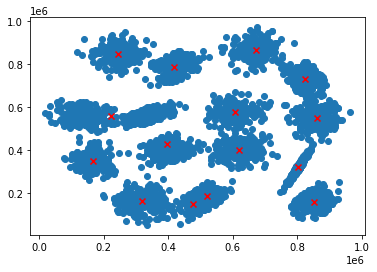

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int,schema=["col1", "col2"]).toPandas()
cluster_centers_pandas = pd.DataFrame(cluster_centers,columns=["col1", "col2"])

plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="r", marker="x")
plt.show()